In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, precision_recall_curve

In [2]:
#read csv
data = pd.read_csv('/content/drive/MyDrive/prescinto Assignment/Fault_Classification_Assignment/Dataset_assignment.csv')

In [ ]:
#################################### data exploration ################################
data.head()

,date_time,device_id,factor1,factor2,factor3,factor4,factor5,factor6,factor7,fault_name,fault_class
0,18-01-2018 08:00,1,27.2,60.0,39.5,706.1,172.800000,8.2,0.0,Inverter Status Alarm,no
1,18-01-2018 17:15,1,26.2,101.0,37.4,736.2,169.633333,20.6,0.0,Inverter Status Alarm,no
2,19-01-2018 08:30,1,31.3,55.0,45.9,720.0,172.700000,7.7,1.0,Inverter Status Alarm,no
3,19-01-2018 17:15,1,31.3,114.0,43.3,764.4,170.900000,18.8,1.0,Inverter Status Alarm,no
4,19-01-2018 17:30,1,15.5,54.0,24.0,684.8,170.466667,17.0,1.0,Inverter Status Alarm,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date_time    9129 non-null   object 
 1   device_id    9129 non-null   int64  
 2   factor1      9129 non-null   float64
 3   factor2      9129 non-null   float64
 4   factor3      9129 non-null   float64
 5   factor4      9129 non-null   float64
 6   factor5      9129 non-null   float64
 7   factor6      9129 non-null   float64
 8   factor7      9129 non-null   float64
 9   fault_name   9129 non-null   object 
 10  fault_class  9129 non-null   object 
dtypes: float64(7), int64(1), object(3)
memory usage: 784.6+ KB


No Null values in the columns

3 string (object) columns

-date_time will need to be broken down


In [ ]:
#Count the unique values of the columns
for col in ['device_id', 'fault_name', 'fault_class']:
  print('Unique values in',col, ': ', data[col].nunique())

Unique values in device_id :  14
Unique values in fault_name :  11
Unique values in fault_class :  2


In [ ]:
np.unique(data['fault_name']) 

array(['Inverter Error Status Alarm', 'Inverter Status Alarm',
       'Invertrer DC Status', 'Message Faukt 1', 'Message Fault 1',
       'Message Fault 2', 'Message Fault 3', 'Message Fault 4',
       'Message Fault 5', 'Message Fault 6', 'Message Fault 7'],
      dtype=object)

Message Faukt 1 and Message Fault 1 seem to be the same (with typo in one)

In [ ]:
#look at values in 'fault_name' where fault_class= 'no'
np.unique(data[data['fault_class'] == 'no']['fault_name'])

array(['Inverter Error Status Alarm', 'Inverter Status Alarm',
       'Invertrer DC Status', 'Message Faukt 1', 'Message Fault 1',
       'Message Fault 2', 'Message Fault 3', 'Message Fault 4',
       'Message Fault 5', 'Message Fault 6', 'Message Fault 7'],
      dtype=object)

We will ignore **fault_name** column

In [23]:
#convert date_time to datetime
data_new = data.copy()
data_new['date_time'] = pd.to_datetime(data_new['date_time'])
data_new = data_new.set_index(['date_time'])
data_new = data_new.resample('1d').mean()

In [24]:
#see range of date
print(data_new.index[0], data_new.index[data_new.shape[0]-1])

2018-01-02 00:00:00 2020-12-11 00:00:00


35 months worth of data




In [25]:
#normalize data_new before seeing correlation
data_new = pd.DataFrame(normalize(data_new.dropna()), columns = data_new.columns)

In [26]:
data_new.head(2)

,device_id,factor1,factor2,factor3,factor4,factor5,factor6,factor7
0,0.010878,0.028227,0.102582,0.043814,0.964355,0.236807,0.024138,0.001102
1,0.011346,0.040613,0.078579,0.066141,0.959332,0.258329,0.024918,0.000420


0


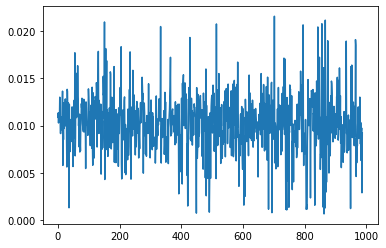

1


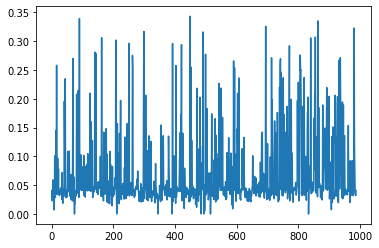

2


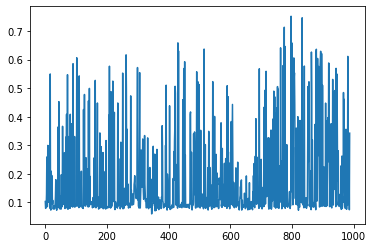

3


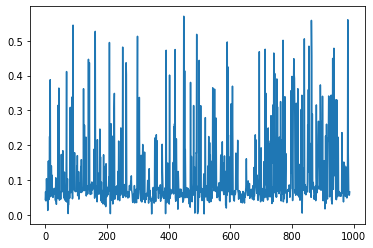

4


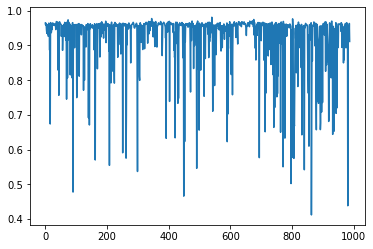

5


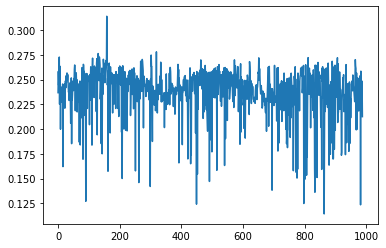

6


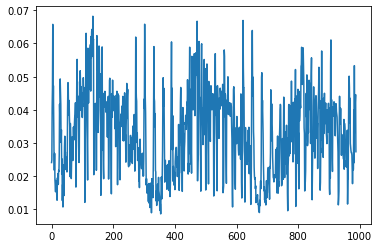

7


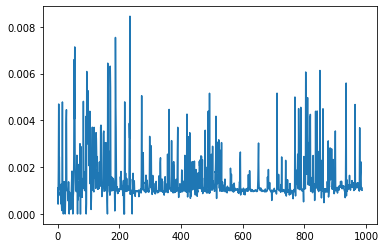

In [11]:
#view the data distribution
for col in data_new.columns:
  print(col)
  data_new[col].plot()
  plt.show()

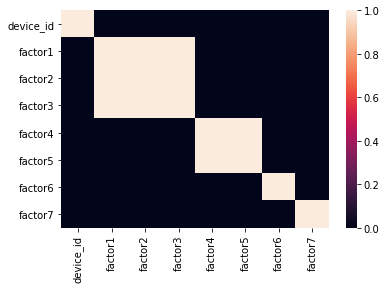

In [32]:
#see heatmap
sns.heatmap(data_new.corr()>0.7) #only significant correlation

**factor1 , factor2 , factor3**  are correlated and will need to be dealt with. Multicolinearity is not desirable.

**factor4 and factor5** are also quite closely related.

In [33]:
#encode our target class variable into 0/1 to better see the correlation with all columns
data['class'] = [0]*data.shape[0]
data.loc[data['fault_class']== 'no', 'class'] = 0
data.loc[data['fault_class']== 'yes', 'class'] = 1


In [ ]:
data.head()

,date_time,device_id,factor1,factor2,factor3,factor4,factor5,factor6,factor7,fault_name,fault_class,class
0,18-01-2018 08:00,1,27.2,60.0,39.5,706.1,172.800000,8.2,0.0,Inverter Status Alarm,no,0
1,18-01-2018 17:15,1,26.2,101.0,37.4,736.2,169.633333,20.6,0.0,Inverter Status Alarm,no,0
2,19-01-2018 08:30,1,31.3,55.0,45.9,720.0,172.700000,7.7,1.0,Inverter Status Alarm,no,0
3,19-01-2018 17:15,1,31.3,114.0,43.3,764.4,170.900000,18.8,1.0,Inverter Status Alarm,no,0
4,19-01-2018 17:30,1,15.5,54.0,24.0,684.8,170.466667,17.0,1.0,Inverter Status Alarm,no,0


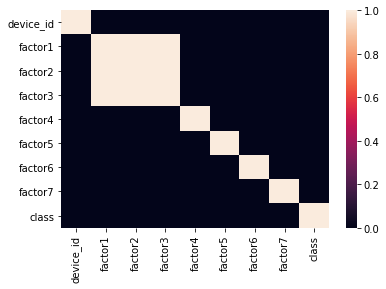

In [34]:
sns.heatmap(data.corr()>0.7)

No linear relationship between fault_class and the rest of the columns.

So there could be a non-linear relationship between them.

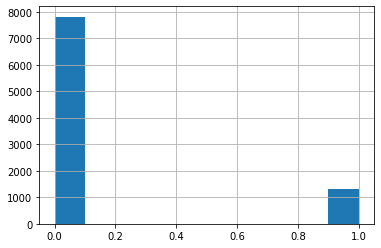

In [35]:
#see distribution of target class
data['class'].hist()

Imbalanced data- 'no' fault class is very high in number

In [ ]:
#find ratio of classes
n = len(data[data['class'] == 0])
y = data.shape[0] - n
ratio = np.float(n//y).as_integer_ratio()
print("Ratio of classes No:Yes = ", ratio)

Ratio of classes No:Yes =  (5, 1)


*********** BASE MODEL ****************

In [36]:
new_data = data[['factor1', 'factor2', 'factor3', 'factor4', 'factor5', 'factor6', 'factor7', 'fault_class']]

In [38]:
#standardize values in data
sc = StandardScaler()
new_data_norm = pd.DataFrame(sc.fit_transform(new_data.iloc[:, 0:-1]), columns = new_data.columns[0:-1])

In [39]:
new_data_norm.head(3)

,factor1,factor2,factor3,factor4,factor5,factor6,factor7
0,-0.273384,-0.432650,-0.295343,0.399215,0.202022,-1.327922,-1.211180
1,-0.283310,-0.245807,-0.308211,0.800724,-0.110524,-0.074149,-1.211180
2,-0.232687,-0.455436,-0.256127,0.584630,0.192152,-1.378478,-0.006353


In [40]:
#random forest and look at feature importance

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(new_data_norm, data.iloc[:, -1])
rf.feature_importances_

array([0.45235579, 0.01146584, 0.35056682, 0.17912287, 0.00308446,
       0.00266471, 0.00073951])

Features that are important: **factor1, factor3, factor4**

---------------------------------------------------------------------

In [ ]:
#feature extraction from date_time and see feature importance again

new_data['minute'] = pd.to_datetime(data['date_time']).dt.minute
new_data['hour'] = pd.to_datetime(data['date_time']).dt.hour
new_data['day'] = pd.to_datetime(data['date_time']).dt.day
new_data['month'] = pd.to_datetime(data['date_time']).dt.month
new_data['year'] = pd.to_datetime(data['date_time']).dt.year   

new_data.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,factor1,factor2,factor3,factor4,factor5,factor6,factor7,fault_class,minute,hour,day,month,year
0,27.2,60.0,39.5,706.1,172.800000,8.2,0.0,no,0,8,18,1,2018
1,26.2,101.0,37.4,736.2,169.633333,20.6,0.0,no,15,17,18,1,2018
2,31.3,55.0,45.9,720.0,172.700000,7.7,1.0,no,30,8,19,1,2018


In [ ]:
new_data['is_fault'] = new_data['fault_class']
new_data = new_data.drop(['fault_class'], axis=1)

In [ ]:
new_data.head(2)

,factor1,factor2,factor3,factor4,factor5,factor6,factor7,minute,hour,day,month,year,is_fault
0,27.2,60.0,39.5,706.1,172.800000,8.2,0.0,0,8,18,1,2018,no
1,26.2,101.0,37.4,736.2,169.633333,20.6,0.0,15,17,18,1,2018,no


In [ ]:
rf.fit(new_data.iloc[:, 0:-1], new_data.iloc[:, -1])
rf.feature_importances_

array([4.36013173e-01, 7.75537341e-03, 3.51720363e-01, 1.94903432e-01,
       2.87900779e-03, 1.80505649e-03, 8.12418606e-04, 3.58039246e-04,
       2.40328774e-03, 6.08754397e-04, 5.12682421e-04, 2.28411297e-04])

The new features were no good!

-----------------------------------------------------------

In [44]:
data.head(2)

,date_time,device_id,factor1,factor2,factor3,factor4,factor5,factor6,factor7,fault_name,fault_class,class
0,18-01-2018 08:00,1,27.2,60.0,39.5,706.1,172.800000,8.2,0.0,Inverter Status Alarm,no,0
1,18-01-2018 17:15,1,26.2,101.0,37.4,736.2,169.633333,20.6,0.0,Inverter Status Alarm,no,0


In [45]:
#Create dataframe from selected features to create our base model and see score
x = new_data_norm
y = data['class']
x.head(2)

,factor1,factor2,factor3,factor4,factor5,factor6,factor7
0,-0.273384,-0.432650,-0.295343,0.399215,0.202022,-1.327922,-1.21118
1,-0.283310,-0.245807,-0.308211,0.800724,-0.110524,-0.074149,-1.21118


In [47]:
y.head(2)

0    0
1    0
Name: class, dtype: int64

In [50]:
np.unique(y)

array([0, 1])

In [51]:
#define model and kFold variable
rf = RandomForestClassifier(n_estimators = 100, random_state= 1) #parameter tuning- find RIC for each parameter combo

kf = KFold(n_splits = 80, random_state=1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:

scores = cross_val_score(rf, x, y.label, scoring='f1', cv=kf)  #using cross validation to make sure the training is performed on all of the data
                                                               #f1score is used to balance precision & recall
print(scores.mean()) #F1 = 89% - 50 KFolds
                    # F1 = 82%  - 80 KFolds

For **AUC** it doesn't even work for 80 k folds as only 1 class gets sampled sometimes and there can not be a score with only 1 class.

We will need to address the imbalanced class problem after all.


In [ ]:
#weighted classes in Random Forest
rf = RandomForestClassifier(n_estimators = 100, random_state= 1, class_weight={0:1, 1:5}) #parameter tuning- find RIC for each parameter combo
kf = KFold(n_splits = 15, random_state=0)

scores1 = cross_val_score(rf, x, y.label, scoring='roc_auc', cv=kf)  
                                     
print(scores1.mean()) #AUC = 100%

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


1.0


Potentially **Misleading score** . Need more analysis.

*************Weighted SVM model*****************

In [ ]:

svm = SVC(gamma = 'scale', class_weight =  {0:1, 1:5}) #parameter tuning
kf = KFold(n_splits = 15, random_state=0)

scoressvm = cross_val_score(svm, x, y.label, scoring='roc_auc', cv=kf)  #using cross validation to make sure the training is performed on all of the data
  
print(scoressvm.mean()) #AUC = 99.89%


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9989963136310703


Okay, close to Random Forest!

But still **can not** yet be accepted.

*************OverSampling & UnderSampling ************

In [52]:
!pip install imblearn

In [53]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
sampling = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')) #parameter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [54]:
#apply sampling method
X, Y= sampling.fit_resample(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [55]:
import collections
collections.Counter(Y)  #see the sizes of the two classes

Counter({0: 7812, 1: 7816})

In [56]:
#split the resampled data - 80-20
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, train_size=0.8, random_state = 1)

In [57]:
test_x.shape

(3126, 7)

In [98]:
test_y.shape

(3126,)

In [94]:
#use SVM model again with proper regularization for potential overfit (as seen in previous svm model without resampling)
#try different c values
auc_scores = []
for cc in [0.001, 0.005, 0.01, 0.05, 0.1, 1]:
  model = SVC(gamma = 'scale', C= cc)
  model.fit(train_x, train_y)
  #print("F1 score : ", f1_score(test_y, model.predict(test_x))) #99.5%
  auc = roc_auc_score(test_y, model.predict(test_x)) 
  auc_scores.extend([auc])


In [95]:
auc_scores

[0.9400149987576083,
 0.9543720928138186,
 0.9617730218034615,
 0.9791628204377721,
 0.9855896898278214,
 0.9971351308645695]

Even with the strictest regularization, C= 0.001, auc = 0.94 

No handles with labels found to put in legend.


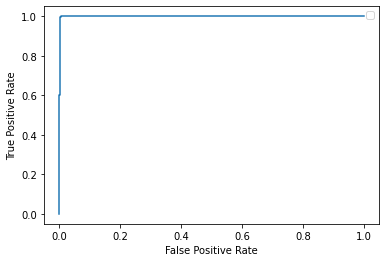

In [151]:
#roc curve

model = SVC(gamma = 'scale', C= 1, probability= True)
model.fit(train_x, train_y)
#print("F1 score : ", f1_score(test_y, model.predict(test_x))) #99.5%
fpr, tpr, _= roc_curve(test_y, model.predict_proba(test_x)[:,1]) 

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.show()

The ROC curve shows the model performance is good overall.

In [152]:
#confusion matrix
confusion_matrix(test_y, model.predict(test_x))

array([[1565,    8],
       [   1, 1552]])

FN=1, FP = 8

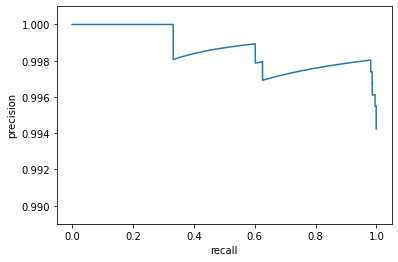

In [148]:
#Precision vs recall curve
precision, recall, _ = precision_recall_curve(test_y, model.predict_proba(test_x)[:,1])
plt.ylim(0.989, 1.001)  #the scale is important to visualize it correctly
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

So it is officially 0.99 auc score with SVM model(C=1).

#--------------------------- XXXXXXXXXXX -----------------------------------------------